In [63]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [64]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:                
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

In [65]:
FOLDER = 'resources/'

import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv', dtype={'st_from':str, 'st_to':str})
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str, 'oper_location':str,
                                                                 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 'depot':str,
                                                                      'st_from':str, 'st_to':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                 'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Log time: %d, %s' % (current_time, time.ctime(current_time)))
print('Read csvs:', np.round(time.time() - start_time, 2), 'sec')

Log time: 1466062285, Thu Jun 16 10:31:25 2016
Read csvs: 0.82 sec


In [66]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
add_info(train_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [67]:
def nice_time(t):
    return time.strftime(time_format, time.localtime(t)) if t > 0 else ''

In [68]:
add_header('Анализ расхождений времен хода поездов и времен хода в нитках', h=2, p=False)

### Загружаем нитки, преобразуем все времена в datetime

In [69]:
slot = pd.read_csv(FOLDER + 'slot.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot)
slot['tt'] = slot.time_end - slot.time_start
slot['link_name'] = list(zip(slot.st_from_name, slot.st_to_name))
slot['dt_from'] = slot.time_start.apply(lambda x: datetime.datetime.fromtimestamp(x))
slot['dt_to'] = slot.time_end.apply(lambda x: datetime.datetime.fromtimestamp(x))

### Для каждой нитки делаем resample до трехчасового интервала и ищем среднее время хода

#### TO DO: Подумать, как переписать: работает очень долго

In [70]:
tracks = slot.dropna(subset=['st_from_name', 'st_to_name'], how='any').link_name.unique()
res = {}
for track in tracks:
    a = slot[slot.link_name == track].set_index('dt_from').resample('3H', how={'tt':np.mean})
    for i in a.index:
        res[(track, i)] = a.ix[i]

slot_3h_durations = pd.DataFrame.from_dict(res, orient='index')
df_3h = slot_3h_durations.reset_index()
df_3h.columns = ['link_name', 'dt_from', 'tt']
df_3h.head()

,link_name,dt_from,tt
0,"(АБАЗА, АСКИЗ)",2016-06-15 21:00:00,4980
1,"(АБАЗА, АСКИЗ)",2016-06-16 00:00:00,7140
2,"(АБАЗА, АСКИЗ)",2016-06-16 03:00:00,6840
3,"(АБАЗА, АСКИЗ)",2016-06-16 06:00:00,7140
4,"(АБАЗА, АСКИЗ)",2016-06-16 09:00:00,6600


### Для каждого поезда находим начало трехчасового интервала для времени отправления

In [71]:
train_plan['dt_from'] = train_plan.time_start.apply(datetime.datetime.fromtimestamp)
a = train_plan.set_index('dt_from').resample('3H', how={'time_start':min}).to_dict()['time_start']
train_plan['dt_3h'] = train_plan.time_start.apply(lambda x: max([key for key, value in a.items() if value <= x]))
train_plan[['train', 'time_start', 'dt_from', 'dt_3h']].head()

,train,time_start,dt_from,dt_3h
0,999912408032000,1466106900,2016-06-16 22:55:00,2016-06-16 21:00:00
1,999912408032000,1466108400,2016-06-16 23:20:00,2016-06-16 21:00:00
2,999912408032000,1466109600,2016-06-16 23:40:00,2016-06-16 21:00:00
3,999912408032000,1466114133,2016-06-17 00:55:33,2016-06-17 00:00:00
4,999912408032000,1466116833,2016-06-17 01:40:33,2016-06-17 00:00:00


### Подставляем в поездные планы среднее время хода из нитки

In [72]:
train_plan['link_name'] = list(zip(train_plan.st_from_name, train_plan.st_to_name))
train_plan['dt_link_name'] = list(zip(train_plan.link_name, train_plan.dt_3h))
df_3h['dt_link_name'] = list(zip(df_3h.link_name, df_3h.dt_from))
train_plan['slot_tt'] = train_plan.dt_link_name.map(df_3h.set_index('dt_link_name').tt)
train_plan.slot_tt.fillna(-1, inplace=True)

### Считаем красивую статистику

#### Гистограмма отклонений времен хода поездов от времен хода в нитках

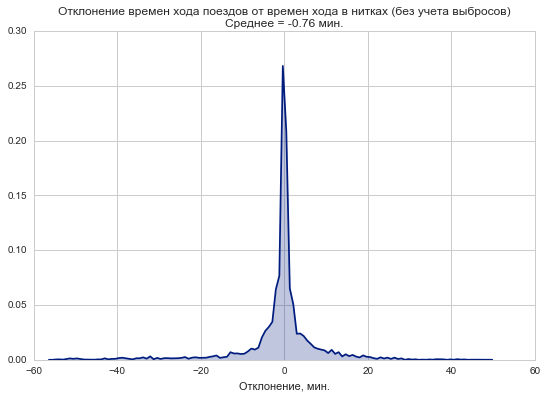

In [73]:
train_plan['tt'] = train_plan.time_end - train_plan.time_start
train_plan['slot_tt'] = train_plan.slot_tt.apply(int)
train_plan['tt_delta'] = train_plan.tt - train_plan.slot_tt
train_plan['tt_delta_abs'] = train_plan.tt_delta.apply(abs)
add_info(links)
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
train_plan['tt_link'] = train_plan.link_name.map(links.drop_duplicates('link_name').set_index('link_name').time)
df_tt_delta = train_plan[train_plan.slot_tt != -1]
tt_delta_mean = df_tt_delta.tt_delta.mean()
tt_delta_std = df_tt_delta.tt_delta.std()
main = df_tt_delta[df_tt_delta.tt_delta.apply(lambda x: np.abs(x - tt_delta_mean) < 3 * tt_delta_std)]

sns.set(context='notebook', style='whitegrid', palette='dark')
fig = plt.figure()
ax = sns.distplot(main.tt_delta / 60, hist=False, kde_kws={'shade':True})
title = 'Отклонение времен хода поездов от времен хода в нитках (без учета выбросов)\nСреднее = %.2f мин.' \
            % (main.tt_delta.mean() / 60)
ax.set(title=title, xlabel='Отклонение, мин.')
filename = 'main_delta.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Выбросы (большие отклонения времен хода поездов от времен хода в нитках)

Всего 660 случаев, когда время хода поезда существенно отличается от времени хода в нитке (выбросы).
Частота выбросов по участку и трехчасовому интервалу:
link_name                   dt_3h              
(ЗАВИТАЯ, БЕЛОГОРСК II)     2016-06-16 18:00:00    24
(ХАБАРОВСК II, КРУГЛИКОВО)  2016-06-17 18:00:00    16
(ОБЛУЧЬЕ, АРХАРА)           2016-06-16 15:00:00    15
(ХАБАРОВСК II, КРУГЛИКОВО)  2016-06-16 18:00:00    14
(ОБЛУЧЬЕ, АРХАРА)           2016-06-16 18:00:00    14
(ЗАВИТАЯ, БЕЛОГОРСК II)     2016-06-17 15:00:00    14
                            2016-06-16 15:00:00    14
                            2016-06-17 18:00:00    14
(БЕЛОГОРСК II, ЗАВИТАЯ)     2016-06-17 21:00:00    13
                            2016-06-16 15:00:00    12


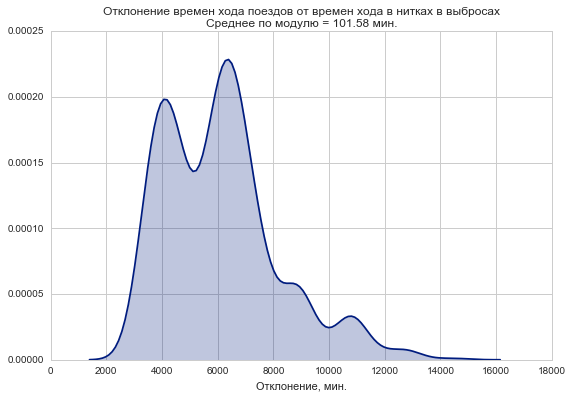

In [74]:
outliers = df_tt_delta[df_tt_delta.tt_delta.apply(lambda x: np.abs(x - tt_delta_mean) > 3 * tt_delta_std)]
cols = ['train', 'st_from_name', 'st_to_name', 'dt_from', 'dt_3h', 'tt', 'slot_tt', 'tt_delta', 'tt_link']
add_header('Всего %d случаев, когда время хода поезда существенно отличается от времени хода в нитке (выбросы).' 
          % outliers.train.count())
add_header('Частота выбросов по участку и трехчасовому интервалу:')
add_line(outliers.groupby(['link_name', 'dt_3h']).train.count().sort_values(ascending=False).head(10))

fig = plt.figure()
sns.set(context='notebook', style='whitegrid', palette='dark')
ax = sns.distplot(outliers.tt_delta.apply(abs), hist=False, kde_kws={'shade':True})
title = 'Отклонение времен хода поездов от времен хода в нитках в выбросах\nСреднее по модулю = %.2f мин.' \
            % (outliers.tt_delta_abs.mean() / 60)
ax.set(title=title, xlabel='Отклонение, мин.')
filename = 'outliers_delta.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Подробная статистика по участку, где больше всего выборосов

In [75]:
cols = ['train', 'st_from_name', 'st_to_name', 'time_start', 'dt_from', 'tt', 'slot_tt', 'tt_delta_abs', 'tt_link']
l = outliers.groupby(['link_name', 'dt_3h']).train.count().sort_values(ascending=False).reset_index().ix[0].link_name
st_from, st_to = l[0], l[1]
add_header('Статистика по участку с наибольшим количеством выбросов: %s -- %s' % (st_from, st_to), h=3)
add_header('Статистика по ниткам:')
add_line(slot[(slot.st_from_name == st_from) & (slot.st_to_name == st_to)].tt.describe())
add_header('Статистика по выбросам в поездных планах:')
add_line(outliers[(outliers.st_from_name == st_from) & (outliers.st_to_name == st_to)].tt.describe())
add_header('Примеры поездов с временами хода, значительно отличающимися от времен в нитках:')
add_line(outliers[(outliers.st_from_name == st_from) & (outliers.st_to_name == st_to)].sort_values('tt_delta_abs', ascending=False)[cols].head(10))

Статистика по участку с наибольшим количеством выбросов: ЗАВИТАЯ -- БЕЛОГОРСК II
Статистика по ниткам:
count      158.000000
mean      7168.101266
std       1579.684783
min       6900.000000
25%       6960.000000
50%       6960.000000
75%       6960.000000
max      21060.000000
Статистика по выбросам в поездных планах:
count      84.000000
mean      619.738095
std       444.032103
min       540.000000
25%       540.000000
50%       540.000000
75%       540.000000
max      3596.000000
Примеры поездов с временами хода, значительно отличающимися от времен в нитках:
          train st_from_name    st_to_name  time_start             dt_from   tt  slot_tt  tt_delta_abs  tt_link
   200254357755      ЗАВИТАЯ  БЕЛОГОРСК II  1466170318 2016-06-17 16:31:58  540     7053          6513      540
   200254290676      ЗАВИТАЯ  БЕЛОГОРСК II  1466083094 2016-06-16 16:18:14  540     7053          6513      540
   200254307227      ЗАВИТАЯ  БЕЛОГОРСК II  1466086663 2016-06-16 17:17:43  540     7053       

In [76]:
add_header('Примеры самых больших (по модулю отклонения) выбросов:', h=3)
add_line(outliers.sort_values('tt_delta_abs', ascending=False)[cols].head(10))

Примеры самых больших (по модулю отклонения) выбросов:
          train st_from_name               st_to_name  time_start             dt_from     tt  slot_tt  tt_delta_abs  tt_link
   220201205815      СЕЛЬГОН                    МЫЛКИ  1466090460 2016-06-16 18:21:00   9720    24180         14460     9720
   200254356353      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466084400 2016-06-16 16:40:00  10980    23760         12780    10980
   200254603352      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466088853 2016-06-16 17:54:13  10980    23760         12780    10980
   200254330814      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466083800 2016-06-16 16:30:00  10980    23760         12780    10980
 88880010704605      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466088853 2016-06-16 17:54:13  10980    23760         12780    10980
   200254354408      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466080200 2016-06-16 15:30:00  10980    23760         12780    10980
   200254569449      СЕЛЬГОН            ВОЛОЧАЕВКА II  1466084118 2016

## Проверка входных данных

### Участки планирования без слотов

In [77]:
slot['link_name'] = list(zip(slot.st_from_name, slot.st_to_name))
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
slot.dropna(subset=['st_from_name', 'st_to_name'], how='any', inplace=True)

In [78]:
slot['tt'] = slot.time_end - slot.time_start
links['slot_tt_init'] = links.link_name.map(slot.groupby('link_name').tt.mean())
links['slot_tt'] = 60 * (links.slot_tt_init // 60)
links[['link_name', 'time', 'slot_tt']]
links_no_slots = links[links.slot_tt.isnull()]
links_no_slots_names = links_no_slots.link_name.unique()
add_header('Всего %d участков планирования без слотов:' % len(links_no_slots_names))
add_line(links_no_slots_names)

Всего 70 участков планирования без слотов:
[('СОЛОВЬЕВСК', 'БОРЗЯ') ('ЕНИСЕЙ', 'ДИВНОГОРСК') ('БЛЮХЕР', 'БАМБУРОВО')
 ('БИРОФЕЛЬД', 'ЛЕНИНСК') ('ОРОСИТЕЛЬНЫЙ', 'ХОНЫХ') ('УГЛОВАЯ', 'УГОЛЬНАЯ')
 ('БЛОКПОСТ 1571 КМ', 'ДАЛЬНЕРЕЧЕНСК I') ('ПЕРЕВАЛ', 'КАЗАНКАН')
 (nan, 'БИРА') ('БИРОФЕЛЬД', nan) ('ПОСТ-ПОКРОВСКИЙ', 'ПОКРОВКА-ПРИСТАНЬ')
 ('КАЗАНКАН', 'ПЕРЕВАЛ') ('ОУНЭ', 'КУЗНЕЦОВСКИЙ') ('ДИВНОГОРСК', 'ЕНИСЕЙ')
 ('СКОВОРОДИНО', 'РЕЙНОВО') (nan, nan) ('УГОЛЬНАЯ', 'УГЛОВАЯ')
 ('БАМБУРОВО', 'БЛЮХЕР') ('МАХАЛИНО', nan) ('ЭБЕРГАРД', 'ДАЛЬНЕРЕЧЕНСК II')
 (nan, 'БИРОФЕЛЬД') ('БЛОКПОСТ 197 КМ', 'ОУНЭ') ('БАЙКАЛ', 'КУЛТУК')
 ('ШАРЫПОВО', 'ШУШЬ') ('АНГАРСК', 'СУХОВСКАЯ-ЮЖНАЯ')
 ('ЧЕРЕМХОВО', 'МАКАРЬЕВО') ('ПЕРЕВАЛ', 'АНГАРАКАН')
 ('СОЛЛУ', 'ВЫСОКОГОРНАЯ') ('НАХОДКА-ВОСТОЧНАЯ', 'ХМЫЛОВСКИЙ')
 ('ХМЫЛОВСКИЙ', 'НАХОДКА-ВОСТОЧНАЯ') ('БОРЗЯ', 'СОЛОВЬЕВСК')
 ('ГРОДЕКОВО (КИТАЙ)', 'РАССЫПНАЯ ПАДЬ') ('МАКАРЬЕВО', 'ЧЕРЕМХОВО')
 ('АНГАРАКАН', 'ПЕРЕВАЛ') ('ЛУЧКИ', 'НОВОКАЧАЛИНСК') ('ШАРЫПОВО', 'БАЗЫР')
 ('БИРА', n

### Выявление участков с неправильным нормативным временем хода

In [79]:
links['delta_tt_perc'] = 100 * np.abs(links.slot_tt - links.time) / links.slot_tt
links['ratio'] = links.slot_tt / links.time
cols = ['link_name', 'time', 'slot_tt', 'ratio']
#links[(links.slot_tt.isnull() == False)][cols].sort_values('delta_tt_perc', ascending=False).head()
links[(links.slot_tt.isnull() == False)][cols].sort_values('ratio', ascending=False).head()

,link_name,time,slot_tt,ratio
251,"(ЗАВИТАЯ, БЕЛОГОРСК II)",540,7140,13.222222
44,"(БЕЛОГОРСК II, ЗАВИТАЯ)",720,7980,11.083333
224,"(КОМСОМОЛЬСК-НА-АМУРЕ II, ЭВОРОН)",1500,14280,9.520000
237,"(ЭВОРОН, КОМСОМОЛЬСК-НА-АМУРЕ II)",1440,13440,9.333333
217,"(ГРОДЕКОВО II, ВОЗДВИЖЕНСКИЙ)",720,6600,9.166667


Всего 23 участков планирования с заниженным или завышенным временем хода относительно ниток: 
[('НАХОДКА', 'ХМЫЛОВСКИЙ') ('БЕЛОГОРСК II', 'ЗАВИТАЯ')
 ('ПРИГОРОДНЫЙ', 'АЧИНСК II') ('КРУГЛИКОВО', 'ХАБАРОВСК II')
 ('ВОЗДВИЖЕНСКИЙ', 'ГРОДЕКОВО II')
 ('КОМСОМОЛЬСК-НА-АМУРЕ', 'КОМСОМОЛЬСК-НА-АМУРЕ II') ('БАЗАИХА', 'ЗЛОБИНО')
 ('ВОЛОЧАЕВКА II', 'ТУНГУССКИЙ') ('ГРОДЕКОВО II', 'ВОЗДВИЖЕНСКИЙ')
 ('КОМСОМОЛЬСК-НА-АМУРЕ II', 'ЭВОРОН')
 ('ЭВОРОН', 'КОМСОМОЛЬСК-НА-АМУРЕ II') ('ЗАВИТАЯ', 'БЕЛОГОРСК II')
 ('СЕЛИХИН', 'КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ')
 ('КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ', 'СЕЛИХИН') ('СРЕТЕНСК', 'КУЭНГА')
 ('ХАБАРОВСК II', 'КРУГЛИКОВО') ('РАССЫПНАЯ ПАДЬ', 'ГРОДЕКОВО')
 ('ПОДСИНИЙ', 'АБАКАН') ('КОМСОМОЛЬСК-НА-АМУРЕ II', 'КОМСОМОЛЬСК-НА-АМУРЕ')
 ('ЗЛОБИНО', 'БАЗАИХА') ('ТУНГУССКИЙ', 'ВОЛОЧАЕВКА II')
 ('ХМЫЛОВСКИЙ', 'НАХОДКА') ('ГРОДЕКОВО', 'РАССЫПНАЯ ПАДЬ')]
Примеры завышенных нормативов:
                                       link_name  time  slot_tt     ratio
 (КОМСОМОЛЬСК-НА-АМУ

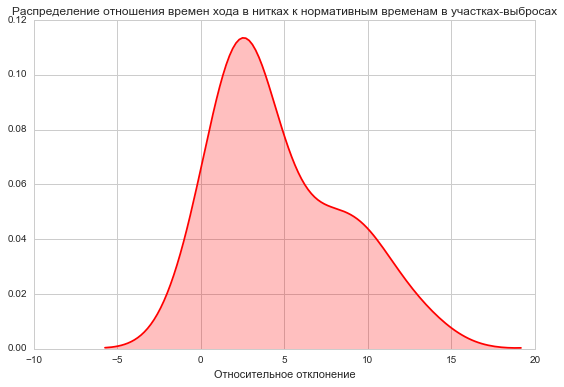

In [80]:
rmean = links.ratio.mean()
rstd = links.ratio.std()
outliers = links[links.ratio.apply(lambda x: np.abs(x - rmean) > rstd)]
add_header('Всего %d участков планирования с заниженным или завышенным временем хода относительно ниток: \n%s' %
          (outliers.link_name.count(), outliers.link_name.unique()))
#sns.distplot(links.ratio, hist=False, color='b', kde_kws={'shade':True})
add_header('Примеры завышенных нормативов:')
add_line(outliers.sort_values('ratio')[cols].head())
add_header('Примеры заниженных нормативов:')
add_line(outliers.sort_values('ratio')[cols].tail())
add_header('Свойства распределения выбросов:')
add_line(outliers.ratio.describe())

fig = plt.figure()
sns.set(context='notebook', style='whitegrid', palette='dark')
ax = sns.distplot(outliers.ratio, hist=False, color='r', kde_kws={'shade':True})
title = 'Распределение отношения времен хода в нитках к нормативным временам в участках-выбросах'
ax.set(title=title, xlabel='Относительное отклонение')
filename = 'outliers_slot_tt_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [81]:
filename = REPORT_FOLDER + 'slot_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/slot_report_20160616_144411.html


In [82]:
slot[(slot.st_from_name == 'ЗАВИТАЯ') & (slot.st_to_name == 'БЕЛОГОРСК II')].sort_values('time_start')[['slot', 'time_start_norm']]

,slot,time_start_norm
11484,200253685115,"Jun 15, 22:49"
11566,200253685142,"Jun 15, 23:04"
13586,200253704701,"Jun 15, 23:19"
11908,200253694791,"Jun 15, 23:32"
12088,200253694821,"Jun 15, 23:49"
12214,200253694856,"Jun 16, 00:05"
12273,200253694887,"Jun 16, 00:20"
12402,200253694907,"Jun 16, 01:05"
13054,200253695081,"Jun 16, 01:20"
12856,200253695049,"Jun 16, 01:38"
